In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from src.data.some_dataloader import RedditDataset

title = RedditDataset("data/soc-redditHyperlinks-title.tsv").data
body = RedditDataset("data/soc-redditHyperlinks-body.tsv").data

LINK_SENTIMENT year_month   -1     1  ratio_per_month
0                 2013-12    1     6         6.000000
1                 2014-01  331  4109        12.413897
2                 2014-02  330  4101        12.427273
3                 2014-03  462  4921        10.651515
4                 2014-04  387  4603        11.894057


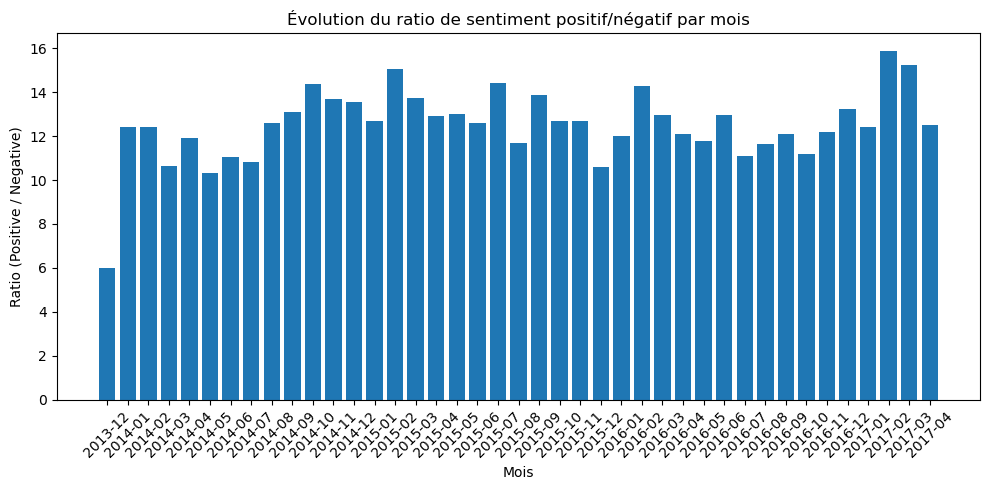

In [ ]:
## ratio positive / negative
title['year_month'] = title['TIMESTAMP'].dt.to_period('M')
body['year_month'] = body['TIMESTAMP'].dt.to_period('M')


monthly_counts = body.groupby(['year_month', 'LINK_SENTIMENT']).size().unstack(fill_value=0)
monthly_counts['ratio_per_month'] = monthly_counts[1] / monthly_counts[-1]
ratio = monthly_counts.reset_index()

print(ratio.head())

plt.figure(figsize=(10,5))
plt.bar(ratio['year_month'].astype(str),ratio['ratio_per_month'])
plt.xticks(rotation=45)
plt.xlabel('Mois')
plt.ylabel('Ratio (Positive / Negative)')
plt.title('Évolution du ratio de sentiment positif/négatif par mois')
plt.tight_layout()
plt.show()